In [20]:
import numpy as np
import pandas as pd
import xgboost as xgb
import scipy.special as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from scipy.stats import gennorm

In [3]:
# Load the CSV file
df = pd.read_csv("../data/cleanv3_transform.csv")

In [10]:
# Filter out rows where 'INCZERO_ONE' or 'INCZERO_TWO' are equal to 1
df_filtered = df[(df['INCZERO_ONE'] != 1) & (df['INCZERO_TWO'] != 1)]

# Build the main dataframe with continuous target and predictors.
df_data = pd.DataFrame({
    "target": df_filtered["INCLOG_DELTA"],
})

continuous_features = ['INCWAGE', 'INCPER', 'EDUC', 'INCTOT', 'NCHILD', 'HEALTH', 'FTOTVAL', 'INCSS', 'AGE', 'INCSSI']
df_cont = df_filtered[continuous_features].copy()

# Append additional continuous features (columns starting with "occ_" or "ind_")
df_hccat = pd.concat([df_filtered.filter(regex="^(occ_|occly_|ind_|indly_)")], axis=1)

# One-hot encode categorical features and add them as predictors.
categorical_features = ['PENSION', 'NATIVITY', 'EMPSTAT', 'SCHLCOLL', 'FAMREL', 'RELATE', 'DIFFHEAR', 'FAMKIND', 'DISABWRK', 'MARST', 'SEX', 'DIFFANY', 'FTYPE', 'LABFORCE', 'MIGRATE1']
ohe = OneHotEncoder(sparse_output=False)
encoded_array = ohe.fit_transform(df_filtered[categorical_features])
encoded_col_names = ohe.get_feature_names_out(categorical_features)
df_cat = pd.DataFrame(encoded_array, columns=encoded_col_names, index=df_filtered.index)

df_data = pd.concat([df_data, df_cont, df_hccat, df_cat], axis=1)

X_all = df_data.drop(columns=["target"]).values
y_all = df_data["target"].values

y_matrix = np.tile(y_all.reshape(-1, 1), (1, 11))

# Split into training and validation sets.
X, X_test, y, y_test = train_test_split(X_all, y_matrix, test_size=0.2, random_state=42)

# Split into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)
dtrain = xgb.DMatrix(X_train, label=y_train)
dall = xgb.DMatrix(X, label=y)

In [11]:
# -------------------------
# Helper functions: activations & transformations
# -------------------------
# Define the clamping constant
EPSILON = 1e-6

# -------------------------
# Helper functions: activations & transformations
# -------------------------
def sigmoid(x):
    """Numerically stable sigmoid function."""
    # Clip input to avoid exp overflow/underflow issues if necessary
    x = np.clip(x, -500, 500)
    return 1.0 / (1.0 + np.exp(-x))

def softplus(x):
    """Numerically stable softplus function."""
    # Clip input to avoid exp overflow issues if necessary
    x = np.clip(x, -500, 500)
    # return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0) # Original - less common form
    return np.log1p(np.exp(x)) # More standard form log(1+exp(x))


def transform_params(raw):
    """
    Transforms raw model output (n_samples x 11) into a dictionary of parameters
    using the specified activation functions (sigmoid for probabilities,
    softplus for positive shape/rate parameters).

    Args:
        raw (np.ndarray): Raw output from the model, shape (n_samples, 11).

    Returns:
        dict: Dictionary containing the transformed parameters:
              rho, pi_pos, pi_neg, alpha_pos1, lambda_pos1, alpha_pos2,
              lambda_pos2, alpha_neg1, lambda_neg1, alpha_neg2, lambda_neg2.
              All values are np.ndarrays of shape (n_samples,).
    """
    params = {}
    # Probabilities (Sigmoid activation)
    params['rho']      = sigmoid(raw[:, 0])  # P(regime=positive)
    params['pi_pos']   = sigmoid(raw[:, 1])  # P(component=1 | regime=positive)
    params['pi_neg']   = sigmoid(raw[:, 2])  # P(component=1 | regime=negative)

    # Gamma parameters (Softplus activation for positivity)
    # Positive Regime Components
    params['alpha_pos1'] = softplus(raw[:, 3]) + EPSILON # Add epsilon for numerical stability
    params['lambda_pos1'] = softplus(raw[:, 4]) + EPSILON # Add epsilon for numerical stability
    params['alpha_pos2'] = softplus(raw[:, 5]) + EPSILON # Add epsilon for numerical stability
    params['lambda_pos2'] = softplus(raw[:, 6]) + EPSILON # Add epsilon for numerical stability
    # Negative Regime Components (applied to t = -y)
    params['alpha_neg1'] = softplus(raw[:, 7]) + EPSILON # Add epsilon for numerical stability
    params['lambda_neg1'] = softplus(raw[:, 8]) + EPSILON # Add epsilon for numerical stability
    params['alpha_neg2'] = softplus(raw[:, 9]) + EPSILON # Add epsilon for numerical stability
    params['lambda_neg2'] = softplus(raw[:, 10]) + EPSILON# Add epsilon for numerical stability
    return params

# -------------------------
# Density functions (Using standard shape α, rate λ parameterization)
# -------------------------
def gamma_pdf(y, alpha, rate_lambda):
    """
    Gamma probability density function (PDF).
    p(y; alpha, lambda) = [lambda^alpha / Gamma(alpha)] * y^(alpha-1) * exp(-lambda*y)
    Assumes y >= EPSILON.
    """
    # Add small constants for numerical stability inside log, pow
    alpha = np.maximum(alpha, EPSILON)
    rate_lambda = np.maximum(rate_lambda, EPSILON)
    y = np.maximum(y, EPSILON) # Ensure y is positive for log

    log_pdf = (alpha * np.log(rate_lambda) - sp.gammaln(alpha) +
               (alpha - 1) * np.log(y) - rate_lambda * y)
    return np.exp(log_pdf)

def mirrored_gamma_pdf(y, alpha, rate_lambda):
    """
    Mirrored Gamma PDF for negative values.
    Transforms y to t = -y, then uses Gamma PDF for t.
    p(y; alpha, lambda) = p_gamma(t=-y; alpha, lambda)
    Assumes y <= -EPSILON.
    """
    t = -y
    # Add small constants for numerical stability inside log, pow
    alpha = np.maximum(alpha, EPSILON)
    rate_lambda = np.maximum(rate_lambda, EPSILON)
    t = np.maximum(t, EPSILON) # Ensure t = -y is positive for log

    log_pdf = (alpha * np.log(rate_lambda) - sp.gammaln(alpha) +
               (alpha - 1) * np.log(t) - rate_lambda * t)
    return np.exp(log_pdf)

# -------------------------
# Custom objective: Analytical gradients and Hessians (Diagonal Approximation).
# -------------------------
def custom_obj(preds, dtrain):
    labels = dtrain.get_label().reshape(-1, 11)
    y = labels[:, 0]  # true target
    
    n = y.shape[0]
    # Reshape raw predictions to (n, 11)
    preds_reshaped = preds.reshape(n, 11)

    # --- Apply Clamping to Target Variable y ---
    y = np.where((y > -EPSILON) & (y < EPSILON), EPSILON, y) # Map [0, eps) to eps
    y = np.where((y < 0) & (y > -EPSILON), -EPSILON, y) # Map (-eps, 0) to -eps
    # Values exactly 0 were already mapped to EPSILON.

    # Transform raw predictions to obtain valid parameters.
    params = transform_params(preds_reshaped)
    rho         = params['rho']
    pi_pos      = params['pi_pos']
    pi_neg      = params['pi_neg']
    alpha_pos1  = params['alpha_pos1']
    lambda_pos1 = params['lambda_pos1']
    alpha_pos2  = params['alpha_pos2']
    lambda_pos2 = params['lambda_pos2']
    alpha_neg1  = params['alpha_neg1']
    lambda_neg1 = params['lambda_neg1']
    alpha_neg2  = params['alpha_neg2']
    lambda_neg2 = params['lambda_neg2']

    # Precompute derivatives of activations (chain rule multipliers)
    # For sigmoid(z), derivative w.r.t z is sigmoid(z) * (1 - sigmoid(z))
    d_sigmoid_rho    = rho * (1 - rho)
    d_sigmoid_pi_pos = pi_pos * (1 - pi_pos)
    d_sigmoid_pi_neg = pi_neg * (1 - pi_neg)
    # For softplus(z) = log(1+exp(z)), derivative w.r.t z is sigmoid(z)
    # We need sigmoid of the *raw* predictions (inputs to softplus)
    d_softplus_alpha_pos1 = sigmoid(preds_reshaped[:, 3])
    d_softplus_lambda_pos1= sigmoid(preds_reshaped[:, 4])
    d_softplus_alpha_pos2 = sigmoid(preds_reshaped[:, 5])
    d_softplus_lambda_pos2= sigmoid(preds_reshaped[:, 6])
    d_softplus_alpha_neg1 = sigmoid(preds_reshaped[:, 7])
    d_softplus_lambda_neg1= sigmoid(preds_reshaped[:, 8])
    d_softplus_alpha_neg2 = sigmoid(preds_reshaped[:, 9])
    d_softplus_lambda_neg2= sigmoid(preds_reshaped[:, 10])

    # Masks for positive and negative regimes based on clamped y
    mask_pos = (y >= EPSILON)
    mask_neg = (y <= -EPSILON)

    # Initialize gradients and Hessians (Diagonal Approximation)
    grad = np.zeros_like(preds_reshaped)
    hess = np.zeros_like(preds_reshaped) # Stores diagonal elements of Hessian approx.

    # --- Numerical Stability Constants ---
    LOG_PDF_FLOOR = -70  # Approx log(1e-30), avoid log(0) or extreme values in densities

    # -------------------------
    # Positive Regime (y >= EPSILON)
    # -------------------------
    if np.any(mask_pos):
        # Select data for this regime
        y_p = y[mask_pos]
        rho_p = rho[mask_pos]
        pi_p = pi_pos[mask_pos]
        a_p1 = alpha_pos1[mask_pos]; l_p1 = lambda_pos1[mask_pos]
        a_p2 = alpha_pos2[mask_pos]; l_p2 = lambda_pos2[mask_pos]
        n_pos = y_p.shape[0]

        # Compute Gamma densities & log densities for components
        log_p_pos1 = np.clip(a_p1 * np.log(l_p1) - sp.gammaln(a_p1) + (a_p1 - 1) * np.log(y_p) - l_p1 * y_p, LOG_PDF_FLOOR, None)
        log_p_pos2 = np.clip(a_p2 * np.log(l_p2) - sp.gammaln(a_p2) + (a_p2 - 1) * np.log(y_p) - l_p2 * y_p, LOG_PDF_FLOOR, None)
        p_pos1 = np.exp(log_p_pos1)
        p_pos2 = np.exp(log_p_pos2)

        # Mixture density within the positive regime
        p_mix_pos = pi_p * p_pos1 + (1 - pi_p) * p_pos2
        p_mix_pos = np.maximum(p_mix_pos, EPSILON**2) # Floor mixture prob

        # Overall likelihood for positive regime observations
        p_overall_pos = rho_p * p_mix_pos
        p_overall_pos = np.maximum(p_overall_pos, EPSILON**2) # Floor overall prob

        # Compute responsibilities (posterior probability of each component given y)
        gamma_pos1 = (pi_p * p_pos1) / p_mix_pos
        gamma_pos2 = ((1 - pi_p) * p_pos2) / p_mix_pos
        # Ensure responsibilities are valid and sum to 1 (approx)
        gamma_pos1 = np.clip(gamma_pos1, 0, 1)
        gamma_pos2 = 1.0 - gamma_pos1 # Use subtraction for consistency

        # --- Calculate Gradients and Hessians (using chain rule) ---
        # Objective is NLL = -log(p_overall_pos)

        # --- Parameter: rho (Gating probability) ---
        # d(NLL)/d(raw_rho) = - d(log p)/d(rho) * d(rho)/d(raw_rho)
        # d(log p)/d(rho) = 1/rho
        grad_rho_p = - (1.0 / rho_p) * d_sigmoid_rho[mask_pos]
        # d²(NLL)/d(raw_rho)² approx - d²(log p)/d(rho)² * [d(rho)/d(raw_rho)]²
        # d²(log p)/d(rho)² = -1/rho²
        hess_rho_p = (1.0 / (rho_p**2)) * (d_sigmoid_rho[mask_pos]**2)
        grad[mask_pos, 0] = grad_rho_p
        hess[mask_pos, 0] = hess_rho_p # Diagonal approximation

        # --- Parameter: pi_pos (Positive mixture weight) ---
        # d(NLL)/d(raw_pi_pos) = - d(log p)/d(pi_pos) * d(pi_pos)/d(raw_pi_pos)
        # d(log p)/d(pi_pos) = d(log(rho * p_mix_pos))/d(pi_pos) = d(log p_mix_pos)/d(pi_pos)
        #                    = (1 / p_mix_pos) * (p_pos1 - p_pos2)
        grad_pi_p = - ((p_pos1 - p_pos2) / p_mix_pos) * d_sigmoid_pi_pos[mask_pos]
        # Hessian approx: Uses square of gradient term w.r.t pi_pos
        hess_pi_p = (((p_pos1 - p_pos2) / p_mix_pos)**2) * (d_sigmoid_pi_pos[mask_pos]**2)
        grad[mask_pos, 1] = grad_pi_p
        hess[mask_pos, 1] = hess_pi_p # Diagonal approximation

        # --- Parameters: alpha_pos1, lambda_pos1 (Component 1) ---
        # d(NLL)/d(param) = - d(log p)/d(param) = - (1/p_overall) * d(p_overall)/d(param)
        #                 = - (1/p_overall) * rho * pi_pos * d(p_pos1)/d(param)
        #                 = - (rho * pi_pos * p_pos1 / p_overall) * d(log p_pos1)/d(param)
        #                 = - (gamma_pos1 * rho_p / p_overall_pos) ?? No, simpler:
        # d(log p)/d(param) = gamma_pos1 * d(log p_pos1)/d(param)
        # Gradient of NLL w.r.t raw param: - gamma_pos1 * d(log p_pos1)/d(param) * d(param)/d(raw)

        # Derivatives of log p_pos1 w.r.t alpha1 and lambda1
        d_logp1_d_a1 = np.log(l_p1) - sp.digamma(a_p1) + np.log(y_p)
        d_logp1_d_l1 = a_p1 / l_p1 - y_p

        grad_a_p1 = - gamma_pos1 * d_logp1_d_a1 * d_softplus_alpha_pos1[mask_pos]
        grad_l_p1 = - gamma_pos1 * d_logp1_d_l1 * d_softplus_lambda_pos1[mask_pos]

        # Hessian approx: gamma_pos1 * d²(NLL_component1)/d(param)² * [d(param)/d(raw)]²
        # d²(NLL_comp1)/d(alpha1)² = -d²(log p1)/d(alpha1)² = sp.polygamma(1, a_p1) # Trigamma
        # d²(NLL_comp1)/d(lambda1)² = -d²(log p1)/d(lambda1)² = a_p1 / (l_p1**2)
        hess_a_p1 = gamma_pos1 * sp.polygamma(1, a_p1) * (d_softplus_alpha_pos1[mask_pos]**2)
        hess_l_p1 = gamma_pos1 * (a_p1 / (l_p1**2)) * (d_softplus_lambda_pos1[mask_pos]**2)

        grad[mask_pos, 3] = grad_a_p1
        grad[mask_pos, 4] = grad_l_p1
        hess[mask_pos, 3] = np.maximum(hess_a_p1, EPSILON) # Ensure non-negative Hessian diag
        hess[mask_pos, 4] = np.maximum(hess_l_p1, EPSILON) # Ensure non-negative Hessian diag

        # --- Parameters: alpha_pos2, lambda_pos2 (Component 2) ---
        # d(log p)/d(param) = gamma_pos2 * d(log p_pos2)/d(param)
        d_logp2_d_a2 = np.log(l_p2) - sp.digamma(a_p2) + np.log(y_p)
        d_logp2_d_l2 = a_p2 / l_p2 - y_p

        grad_a_p2 = - gamma_pos2 * d_logp2_d_a2 * d_softplus_alpha_pos2[mask_pos]
        grad_l_p2 = - gamma_pos2 * d_logp2_d_l2 * d_softplus_lambda_pos2[mask_pos]

        hess_a_p2 = gamma_pos2 * sp.polygamma(1, a_p2) * (d_softplus_alpha_pos2[mask_pos]**2)
        hess_l_p2 = gamma_pos2 * (a_p2 / (l_p2**2)) * (d_softplus_lambda_pos2[mask_pos]**2)

        grad[mask_pos, 5] = grad_a_p2
        grad[mask_pos, 6] = grad_l_p2
        hess[mask_pos, 5] = np.maximum(hess_a_p2, EPSILON)
        hess[mask_pos, 6] = np.maximum(hess_l_p2, EPSILON)


    # -------------------------
    # Negative Regime (y <= -EPSILON)
    # -------------------------
    if np.any(mask_neg):
        # Select data for this regime
        y_n = y[mask_neg]
        t_n = -y_n # Transformed variable t = -y >= EPSILON
        rho_n = rho[mask_neg]
        pi_n = pi_neg[mask_neg]
        a_n1 = alpha_neg1[mask_neg]; l_n1 = lambda_neg1[mask_neg]
        a_n2 = alpha_neg2[mask_neg]; l_n2 = lambda_neg2[mask_neg]
        n_neg = y_n.shape[0]

        # Compute mirrored Gamma densities & log densities for components
        # Use Gamma PDF definition with t = -y
        log_p_neg1 = np.clip(a_n1 * np.log(l_n1) - sp.gammaln(a_n1) + (a_n1 - 1) * np.log(t_n) - l_n1 * t_n, LOG_PDF_FLOOR, None)
        log_p_neg2 = np.clip(a_n2 * np.log(l_n2) - sp.gammaln(a_n2) + (a_n2 - 1) * np.log(t_n) - l_n2 * t_n, LOG_PDF_FLOOR, None)
        p_neg1 = np.exp(log_p_neg1)
        p_neg2 = np.exp(log_p_neg2)

        # Mixture density within the negative regime
        p_mix_neg = pi_n * p_neg1 + (1 - pi_n) * p_neg2
        p_mix_neg = np.maximum(p_mix_neg, EPSILON**2) # Floor mixture prob

        # Overall likelihood for negative regime observations
        p_overall_neg = (1 - rho_n) * p_mix_neg
        p_overall_neg = np.maximum(p_overall_neg, EPSILON**2) # Floor overall prob

        # Compute responsibilities
        gamma_neg1 = (pi_n * p_neg1) / p_mix_neg
        gamma_neg2 = ((1 - pi_n) * p_neg2) / p_mix_neg
        gamma_neg1 = np.clip(gamma_neg1, 0, 1)
        gamma_neg2 = 1.0 - gamma_neg1

        # --- Calculate Gradients and Hessians (using chain rule) ---
        # Objective is NLL = -log(p_overall_neg)

        # --- Parameter: rho (Gating probability) ---
        # d(NLL)/d(raw_rho) = - d(log p)/d(rho) * d(rho)/d(raw_rho)
        # d(log p)/d(rho) = d(log( (1-rho)*p_mix_neg ))/d(rho) = -1 / (1-rho)
        grad_rho_n = - (-1.0 / (1 - rho_n)) * d_sigmoid_rho[mask_neg]
        # Hessian approx: - d²(log p)/d(rho)² * [d(rho)/d(raw_rho)]²
        # d²(log p)/d(rho)² = -1 / (1-rho)²
        hess_rho_n = - (-1.0 / ((1 - rho_n)**2)) * (d_sigmoid_rho[mask_neg]**2)
        grad[mask_neg, 0] = grad_rho_n
        hess[mask_neg, 0] = hess_rho_n # Diagonal approximation

        # --- Parameter: pi_neg (Negative mixture weight) ---
        # d(NLL)/d(raw_pi_neg) = - d(log p)/d(pi_neg) * d(pi_neg)/d(raw_pi_neg)
        # d(log p)/d(pi_neg) = d(log( (1-rho)*p_mix_neg ))/d(pi_neg) = d(log p_mix_neg)/d(pi_neg)
        #                    = (1 / p_mix_neg) * (p_neg1 - p_neg2)
        grad_pi_n = - ((p_neg1 - p_neg2) / p_mix_neg) * d_sigmoid_pi_neg[mask_neg]
        # Hessian approx: Uses square of gradient term w.r.t pi_neg
        hess_pi_n = (((p_neg1 - p_neg2) / p_mix_neg)**2) * (d_sigmoid_pi_neg[mask_neg]**2)
        grad[mask_neg, 2] = grad_pi_n # Index 2 for pi_neg
        hess[mask_neg, 2] = hess_pi_n # Diagonal approximation

        # --- Parameters: alpha_neg1, lambda_neg1 (Component 1) ---
        # d(log p)/d(param) = gamma_neg1 * d(log p_neg1)/d(param)
        # Note: log p_neg1 is log Gamma PDF applied to t = -y
        d_logp1_d_a1 = np.log(l_n1) - sp.digamma(a_n1) + np.log(t_n) # log(t) = log(-y)
        d_logp1_d_l1 = a_n1 / l_n1 - t_n                           # t = -y

        grad_a_n1 = - gamma_neg1 * d_logp1_d_a1 * d_softplus_alpha_neg1[mask_neg]
        grad_l_n1 = - gamma_neg1 * d_logp1_d_l1 * d_softplus_lambda_neg1[mask_neg]

        # Hessian approx: gamma_neg1 * d²(NLL_component1)/d(param)² * [d(param)/d(raw)]²
        # d²(NLL_comp1)/d(alpha1)² = sp.polygamma(1, a_n1)
        # d²(NLL_comp1)/d(lambda1)² = a_n1 / (l_n1**2)
        hess_a_n1 = gamma_neg1 * sp.polygamma(1, a_n1) * (d_softplus_alpha_neg1[mask_neg]**2)
        hess_l_n1 = gamma_neg1 * (a_n1 / (l_n1**2)) * (d_softplus_lambda_neg1[mask_neg]**2)

        grad[mask_neg, 7] = grad_a_n1 # Index 7 for alpha_neg1
        grad[mask_neg, 8] = grad_l_n1 # Index 8 for lambda_neg1
        hess[mask_neg, 7] = np.maximum(hess_a_n1, EPSILON)
        hess[mask_neg, 8] = np.maximum(hess_l_n1, EPSILON)

        # --- Parameters: alpha_neg2, lambda_neg2 (Component 2) ---
        d_logp2_d_a2 = np.log(l_n2) - sp.digamma(a_n2) + np.log(t_n)
        d_logp2_d_l2 = a_n2 / l_n2 - t_n

        grad_a_n2 = - gamma_neg2 * d_logp2_d_a2 * d_softplus_alpha_neg2[mask_neg]
        grad_l_n2 = - gamma_neg2 * d_logp2_d_l2 * d_softplus_lambda_neg2[mask_neg]

        hess_a_n2 = gamma_neg2 * sp.polygamma(1, a_n2) * (d_softplus_alpha_neg2[mask_neg]**2)
        hess_l_n2 = gamma_neg2 * (a_n2 / (l_n2**2)) * (d_softplus_lambda_neg2[mask_neg]**2)

        grad[mask_neg, 9] = grad_a_n2 # Index 9 for alpha_neg2
        grad[mask_neg, 10] = grad_l_n2 # Index 10 for lambda_neg2
        hess[mask_neg, 9] = np.maximum(hess_a_n2, EPSILON)
        hess[mask_neg, 10] = np.maximum(hess_l_n2, EPSILON)

    # --- Final Checks and Return ---
    # Check for NaNs or Infs which can crash XGBoost
    if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
        print("Warning: NaNs or Infs detected in gradient. Check inputs/parameters.")
        grad = np.nan_to_num(grad, nan=0.0, posinf=1e6, neginf=-1e6) # Replace with finite numbers

    if np.any(np.isnan(hess)) or np.any(np.isinf(hess)):
        print("Warning: NaNs or Infs detected in Hessian. Check inputs/parameters.")
        hess = np.nan_to_num(hess, nan=EPSILON, posinf=1e6, neginf=EPSILON) # Replace, ensure positivity

    # Ensure Hessian is non-negative (required by XGBoost)
    hess = np.maximum(hess, EPSILON)

    # Flatten gradients and Hessians for XGBoost.
    return grad.flatten(), hess.flatten()


def custom_eval(preds, dtrain):
    """
    Custom evaluation metric: Computes the average negative log-likelihood (NLL).
    Matches the objective function `custom_neg_log_likelihood_obj`.

    Args:
        preds (np.ndarray): Raw predictions from XGBoost, flat vector.
        dtrain (xgboost.DMatrix): Data matrix containing labels.

    Returns:
        tuple[str, float]: Metric name ('NLL') and the computed average NLL.
    """
     # Recover true target y
    labels = dtrain.get_label().reshape(-1, 11)
    y = labels[:, 0]
    n = y.shape[0]
    preds_reshaped = preds.reshape(n, 11)

    params = transform_params(preds_reshaped)

    # Compute likelihood based on clamped y sign.
    likelihood = np.zeros(n)
    mask_pos = (y > 0)
    mask_neg = (y < 0)

    # --- Numerical Stability ---
    PROB_FLOOR = EPSILON**2

    if np.any(mask_pos):
        y_p = y[mask_pos]
        p_pos1 = gamma_pdf(y_p, params['alpha_pos1'][mask_pos], params['lambda_pos1'][mask_pos])
        p_pos2 = gamma_pdf(y_p, params['alpha_pos2'][mask_pos], params['lambda_pos2'][mask_pos])
        p_mix_pos = (params['pi_pos'][mask_pos] * p_pos1 +
                     (1 - params['pi_pos'][mask_pos]) * p_pos2)
        likelihood[mask_pos] = params['rho'][mask_pos] * p_mix_pos

    if np.any(mask_neg):
        y_n = y[mask_neg]
        p_neg1 = mirrored_gamma_pdf(y_n, params['alpha_neg1'][mask_neg], params['lambda_neg1'][mask_neg])
        p_neg2 = mirrored_gamma_pdf(y_n, params['alpha_neg2'][mask_neg], params['lambda_neg2'][mask_neg])
        p_mix_neg = (params['pi_neg'][mask_neg] * p_neg1 +
                     (1 - params['pi_neg'][mask_neg]) * p_neg2)
        likelihood[mask_neg] = (1 - params['rho'][mask_neg]) * p_mix_neg

    # Avoid log(0)
    likelihood = np.maximum(likelihood, 1e-10)
    nll = -np.log(likelihood)

    # Return metric name and average value
    return 'NLL', np.mean(nll)

In [12]:
# ------------------------------------
# 5. Configure XGBoost for Multi-Output Regression
# ------------------------------------
# We set multi_strategy to "multi_output_tree" to get a vectorized leaf.
xgb_params = {
    "tree_method": "hist",
    "multi_strategy": "one_output_per_tree",
    # "multi_strategy": "multi_output_tree",
    "learning_rate": 0.5,
    "max_depth": 2,
    "min_child_weight": 100,         # require more instances to make a split
    # "gamma": 1,                  # higher minimum loss reduction for a split
    "subsample": 1,              # use 80% of the samples per tree
    "colsample_bytree": 1,       # use 80% of the features per tree
    "reg_alpha": 0,              # L1 regularization
    "reg_lambda": 0,             # L2 regularization
    "verbosity": 1,
    # No "objective" specified; we pass our custom objective.
}

In [13]:
# ------------------------------------
# 6. Train the Model Using XGBoost
# ------------------------------------
num_round = 5000  # Number of boosting rounds

# Use xgb.train() with our custom objective and evaluation metric.
bst = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=num_round,
    obj=custom_obj,
    custom_metric = custom_eval,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=50
)


c:\Users\nickb\anaconda3\Lib\site-packages\xgboost\core.py:2291: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	train-rmse:0.81654	train-NLL:0.33625	val-rmse:0.81701	val-NLL:0.34091
[1]	train-rmse:1.05150	train-NLL:0.26229	val-rmse:1.05187	val-NLL:0.26773
[2]	train-rmse:1.23876	train-NLL:0.22398	val-rmse:1.23913	val-NLL:0.22981
[3]	train-rmse:1.39810	train-NLL:0.19675	val-rmse:1.39825	val-NLL:0.20210
[4]	train-rmse:1.53789	train-NLL:0.17485	val-rmse:1.53759	val-NLL:0.18059
[5]	train-rmse:1.64815	train-NLL:0.15729	val-rmse:1.64790	val-NLL:0.16321
[6]	train-rmse:1.77197	train-NLL:0.14238	val-rmse:1.77172	val-NLL:0.14828
[7]	train-rmse:1.88420	train-NLL:0.13025	val-rmse:1.88364	val-NLL:0.13646
[8]	train-rmse:1.98174	train-NLL:0.12043	val-rmse:1.98105	val-NLL:0.12607
[9]	train-rmse:2.07769	train-NLL:0.11139	val-rmse:2.07697	val-NLL:0.11671
[10]	train-rmse:2.17326	train-NLL:0.10426	val-rmse:2.17233	val-NLL:0.10962
[11]	train-rmse:2.24997	train-NLL:0.09760	val-rmse:2.24915	val-NLL:0.10282
[12]	train-rmse:2.33377	train-NLL:0.09189	val-rmse:2.33300	val-NLL:0.09723
[13]	train-rmse:2.39470	train-NLL:0

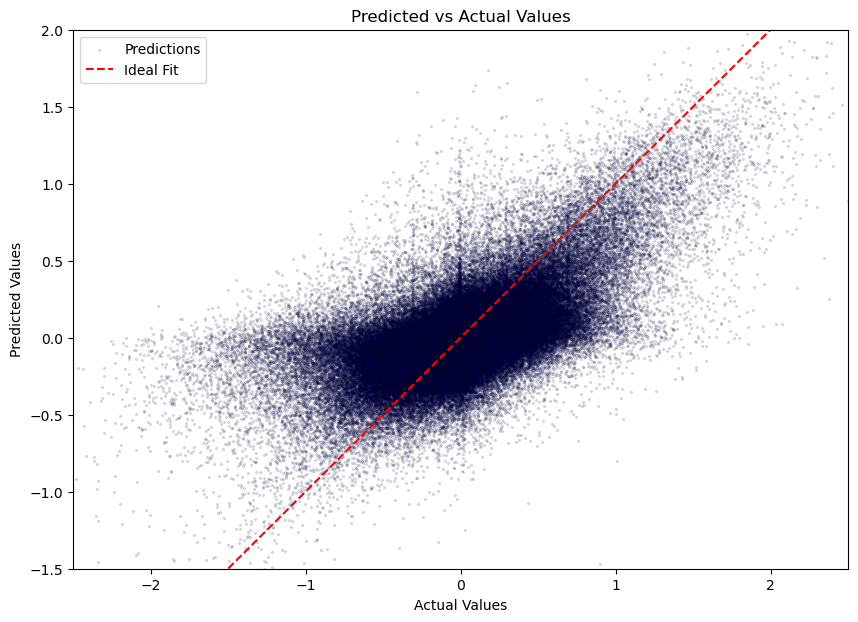

Mean Absolute Error (MAE): 0.20362358896871272


In [18]:
# Prediction using the trained model (bst from previous training).
preds_raw = bst.predict(dtrain).reshape(-1, 11)
predicted_params = transform_params(preds_raw)

# As before, we compute the expected value for each sample:
# For the positive regime: expected value from Gamma is f (with mean f).
f_pos1  = predicted_params["alpha_pos1"]/predicted_params["lambda_pos1"]
f_pos2  =  predicted_params["alpha_pos2"]/predicted_params["lambda_pos2"]
expected_pos = predicted_params["pi_pos"] * f_pos1 + (1 - predicted_params["pi_pos"]) * f_pos2

# For the negative regime: expected value is negative of the scale.
f_neg1  = predicted_params["alpha_neg1"]/predicted_params["lambda_neg1"]
f_neg2  =  predicted_params["alpha_neg2"]/predicted_params["lambda_neg2"]
expected_neg = - (predicted_params["pi_neg"] * f_neg1 + (1 - predicted_params["pi_neg"]) * f_neg2)

rho = predicted_params["rho"]

# Overall prediction is a mixture of both regimes.
y_pred_train = rho * expected_pos + (1 - rho) * expected_neg
y_train_vec = y_train[:,0]

# Plot predicted vs. actual values:
plt.figure(figsize=(10, 7))
plt.scatter(y_train_vec, y_pred_train, c="darkblue", alpha=0.15, edgecolors="black", linewidth=0.5, s=2.5, label="Predictions")
# Plot an ideal 45-degree line (y=x) for reference.
plt.plot([y_train_vec.min(), y_train_vec.max()], [y_train_vec.min(), y_train_vec.max()], 'r--', label="Ideal Fit")
plt.xlim(-2.5, 2.5)
plt.ylim(-1.5, 2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()

# Compute the mean absolute error.
mae = mean_absolute_error(y_train_vec, y_pred_train)
print("Mean Absolute Error (MAE):", mae)

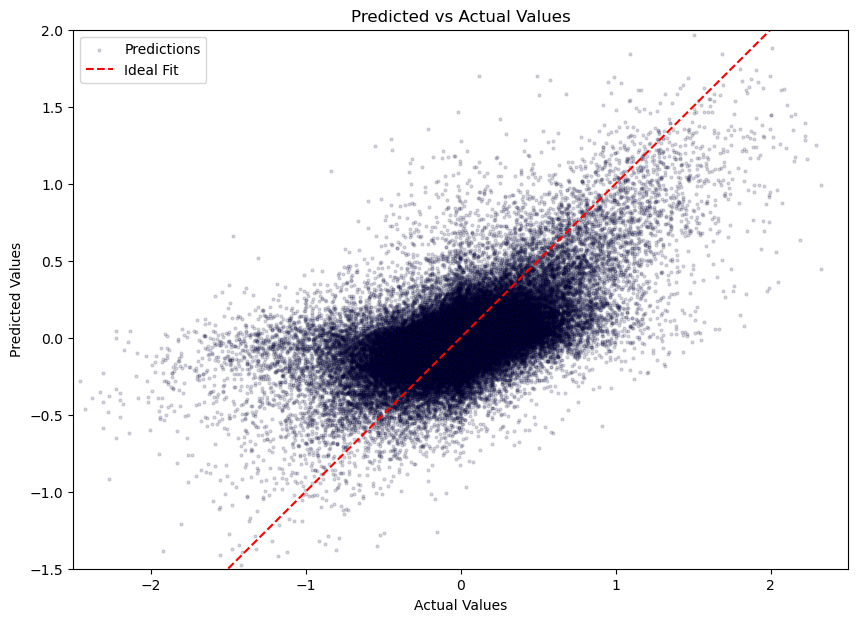

Mean Absolute Error (MAE): 0.20707952555740414


In [19]:
# Prediction using the trained model (bst from previous training).
preds_raw = bst.predict(dtest).reshape(-1, 11)
predicted_params = transform_params(preds_raw)

# As before, we compute the expected value for each sample:
# For the positive regime: expected value from Gamma is f (with mean f).
f_pos1  = predicted_params["alpha_pos1"]/predicted_params["lambda_pos1"]
f_pos2  =  predicted_params["alpha_pos2"]/predicted_params["lambda_pos2"]
expected_pos = predicted_params["pi_pos"] * f_pos1 + (1 - predicted_params["pi_pos"]) * f_pos2

# For the negative regime: expected value is negative of the scale.
f_neg1  = predicted_params["alpha_neg1"]/predicted_params["lambda_neg1"]
f_neg2  =  predicted_params["alpha_neg2"]/predicted_params["lambda_neg2"]
expected_neg = - (predicted_params["pi_neg"] * f_neg1 + (1 - predicted_params["pi_neg"]) * f_neg2)

rho = predicted_params["rho"]

# Overall prediction is a mixture of both regimes.
y_pred_test = rho * expected_pos + (1 - rho) * expected_neg
y_test_vec = y_test[:,0]

# Plot predicted vs. actual values:
plt.figure(figsize=(10, 7))
plt.scatter(y_test_vec, y_pred_test, c="darkblue", alpha=0.15, edgecolors="black", linewidth=0.89, s=4.47, label="Predictions")
# Plot an ideal 45-degree line (y=x) for reference.
plt.plot([y_test_vec.min(), y_test_vec.max()], [y_test_vec.min(), y_test_vec.max()], 'r--', label="Ideal Fit")
plt.xlim(-2.5, 2.5)
plt.ylim(-1.5, 2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()

# Compute the mean absolute error.
mae = mean_absolute_error(y_test_vec, y_pred_test)
print("Mean Absolute Error (MAE):", mae)

Fitted parameters:
Shape (beta): 0.9133793292821157
Location (mu): 0.013899433373814885
Scale (alpha): 0.17681459014941342


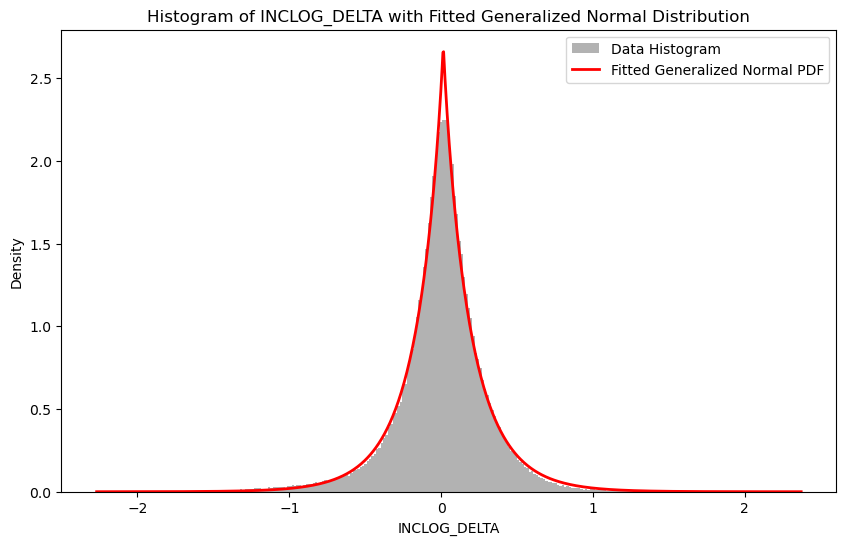

In [21]:
# Assume df_data is your DataFrame and it contains the column "INCLOG_DELTA"
# Remove any missing values and get the data as a numpy array
data = y_train_vec - y_pred_train

# Fit the generalized normal distribution to the data.
# The fit function returns the shape parameter (often called beta),
# as well as the location (mu) and scale (alpha) parameters.
shape, loc, scale = gennorm.fit(data)
print("Fitted parameters:")
print("Shape (beta):", shape)
print("Location (mu):", loc)
print("Scale (alpha):", scale)

alpha_fit = scale

# Generate a sequence of x values over the range of the data to later evaluate the PDF.
x = np.linspace(data.min(), data.max(), 1000)
pdf_values = gennorm.pdf(x, shape, loc=loc, scale=scale)

# Plot the density histogram and the fitted PDF.
plt.figure(figsize=(10, 6))
plt.hist(data, bins=300, density=True, alpha=0.6, color='gray', label='Data Histogram')
plt.plot(x, pdf_values, 'r-', lw=2, label='Fitted Generalized Normal PDF')
plt.xlabel('INCLOG_DELTA')
plt.ylabel('Density')
plt.title('Histogram of INCLOG_DELTA with Fitted Generalized Normal Distribution')
plt.legend()
plt.show()